# Statoil/C-CORE Iceberg Classifier Challenge
## How to get a Top 2% score on kaggle competition (Rank 53/3343)
Link: https://www.kaggle.com/c/statoil-iceberg-classifier-challenge


Drifting icebergs present threats to navigation and activities in areas such as offshore of the East Coast of Canada.

Currently, many institutions and companies use aerial reconnaissance and shore-based support to monitor environmental conditions and assess risks from icebergs. However, in remote areas with unsual harsh weather, these methods are not feasible, and the only viable monitoring option is via satellite.

Statoil, an international energy company operating worldwide, has worked closely with companies like C-CORE. C-CORE has been using satellite data for over 30 years and has built a computer vision based surveillance system. To keep operations safe and efficient, Statoil is interested in getting a fresh new perspective on how to use machine learning to more accurately detect and discriminate against threatening icebergs as early as possible.

In this competition, you’re challenged to build an algorithm that automatically identifies if a remotely sensed target is a ship or iceberg. Improvements made will help drive the costs down for maintaining safe working conditions.

This model implements a Keras + Tensorflow CNN for the StatOil Iceberg competition. It has yielded results of 0.1877 on the leaderboard. We built a general data science pipeline to solve an image classification problem. Computing speeds of CPU and GPU are compared in our model which shows that GPU can save a lot of training time.  We also introduced some techniques pseudo labeling and stacking to improve the classification results. We hope the similar processes can be applied to our text mining project. 

The input is a 75x75x3 set of images. The output is a binary 0/1 where 1 is noted as an iceberg. 

The set of images are band_1 (HH), band_2 (HV), and a combined band which would be (HH dot HV)/constant. However, since we are working with the images in dB, the 3rd band is modified to compensate for the log function yielding band_1 + band_2 -log(constant). The last term is neglected as when the images are scaled the 3rd term would be removed by the mathematics anyway.

This and other information can be found at: https://earth.esa.int/c/document_library/get_file?folderId=409229&name=DLFE-5566.pdf

## Content:



1.   Problem definition: load data, data shape and data visualization
2.   Data engineering: data cleaning, data scaling, data augmentation
3.   CNN keras modeling: apply keras tensorflow convulutional neural network
4.   Pseudo labeling: pseudo label the test to use as a train
5.   Stacking: combine results of five models into one model

## Data science project Pipeline:

<img src= "https://docs.google.com/uc?id=1hcsglQ0XEzbJveUKgwS6EXZWKAHAjL9T" width="120%" height="120%" />



<a id='Introduction'></a>
## 1.Problem definition
### 1.1 Import packages
How to use GPU on google drive: https://zhuanlan.zhihu.com/p/33344222

In [6]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/nullh
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmppiczpg3x/pubring.gpg' created
gpg: /tmp/tmppiczpg3x/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory. otherwise can not read data
!mkdir -p drive
!google-drive-ocamlfuse drive

In [8]:
#install keras 
!pip install -q keras
# install pytorch
!pip install -q http://download.pytorch.org/whl/cu75/torch-0.2.0.post3-cp27-cp27mu-manylinux1_x86_64.whl torchvision
# install cv2 

!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

#install xgboost
!pip install -q xgboost==0.4a30
import xgboost

torch-0.2.0.post3-cp27-cp27mu-manylinux1_x86_64.whl is not a supported wheel on this platform.


In [9]:
# check if GPU works, if '/device:GPU:0', the GPU is using 
import tensorflow as tf
tf.test.gpu_device_name() 

# # which GPU I am using 
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

# # how large is RAM

# !cat /proc/meminfo 

# # what is the CPU

# !cat /proc/cpuinfo 



'/device:GPU:0'

In [0]:
import pandas as pd 
import numpy as np 
import cv2 # Used to manipulated the images 
np.random.seed(1337) # Set the seed to generate same random sequence

# Import Keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
import keras.backend as K
from keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
path_data= "drive/app/iceberg/data/"
path_model="drive/app/iceberg/model/"
path_fig="drive/app/iceberg/fig/"
path_stack= "drive/app/iceberg/stack/"

In [0]:
def limit_men():
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
limit_men()

### 1.2 Data description


Load training data

In [0]:
df_train = pd.read_json(path_data + 'train.json')

The database contains 1604 data sample and five features: band 1, band 2 , id , inc angle, is iceberg

In [18]:
print ( "The shape of database is :", df_train.shape) 
print( "Show the first three examples")
df_train[:3]
print("How many pixels in the each chart",len(df_train["band_1"][0]), 
      "which is equalt to 75*75")

The shape of database is : (1604, 5)
Show the first three examples
How many pixels in the each chart 5625 which is equalt to 75*75


### 1.3 Data visualization

It's good to plot some images before we do too much analysis. That way, we can get some sense of what we're looking at. The images are 75 x 75 pixels each with two bands. We randomly generate 9 ship and iceberg charts for both band 1 and band 2. 

**We can find that some charts are easy to classify and some are not**

In [0]:
# Randomly got 9 ship and iceberg data
icebergs = df_train[df_train.is_iceberg==1].sample(n=9,random_state=123)
ships = df_train[df_train.is_iceberg==0].sample(n=9,random_state=456)

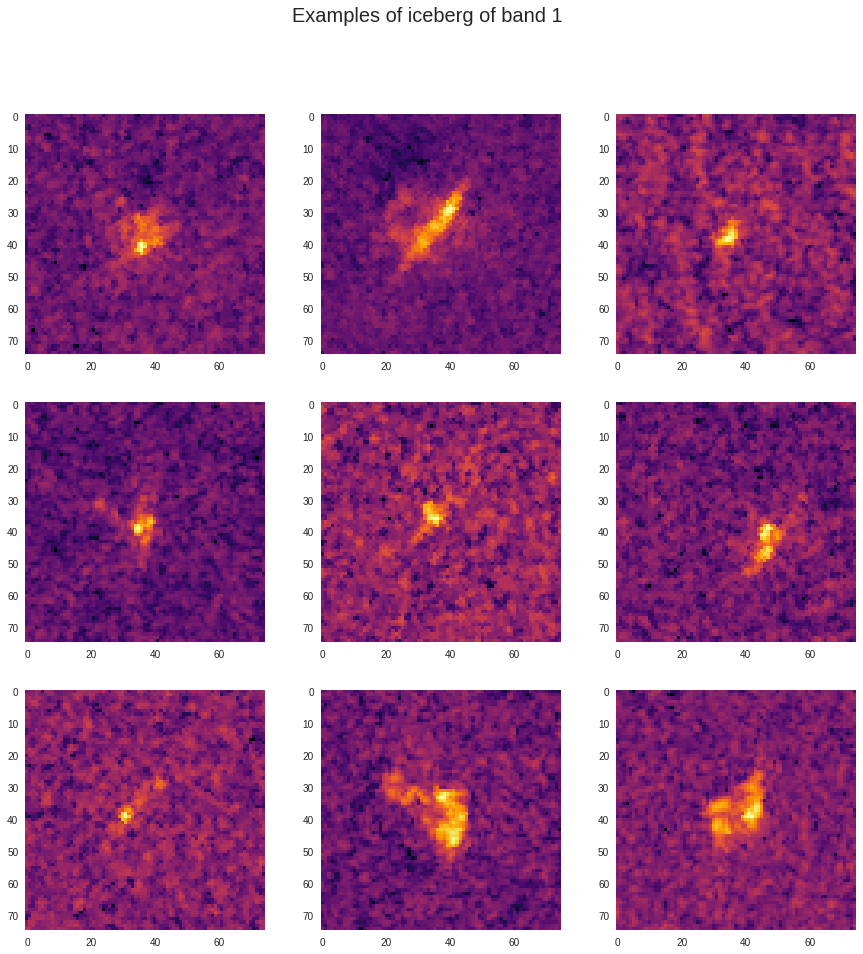

In [20]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,0]),(75,75))
    ax.grid(False)
    ax.imshow(arr,cmap='inferno')
fig.suptitle("Examples of iceberg of band 1",fontsize=20)    
plt.show()

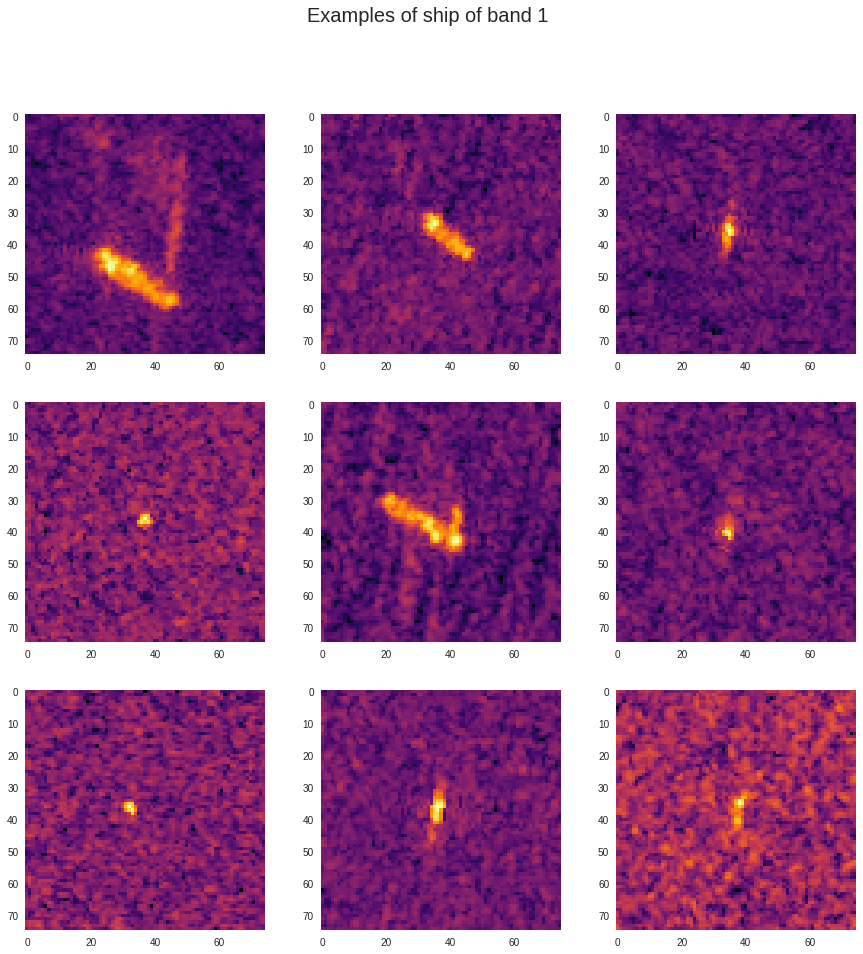

In [21]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,0]),(75,75))
    ax.grid("False")
    ax.imshow(arr,cmap='inferno')
fig.suptitle("Examples of ship of band 1",fontsize=20)    
plt.show()

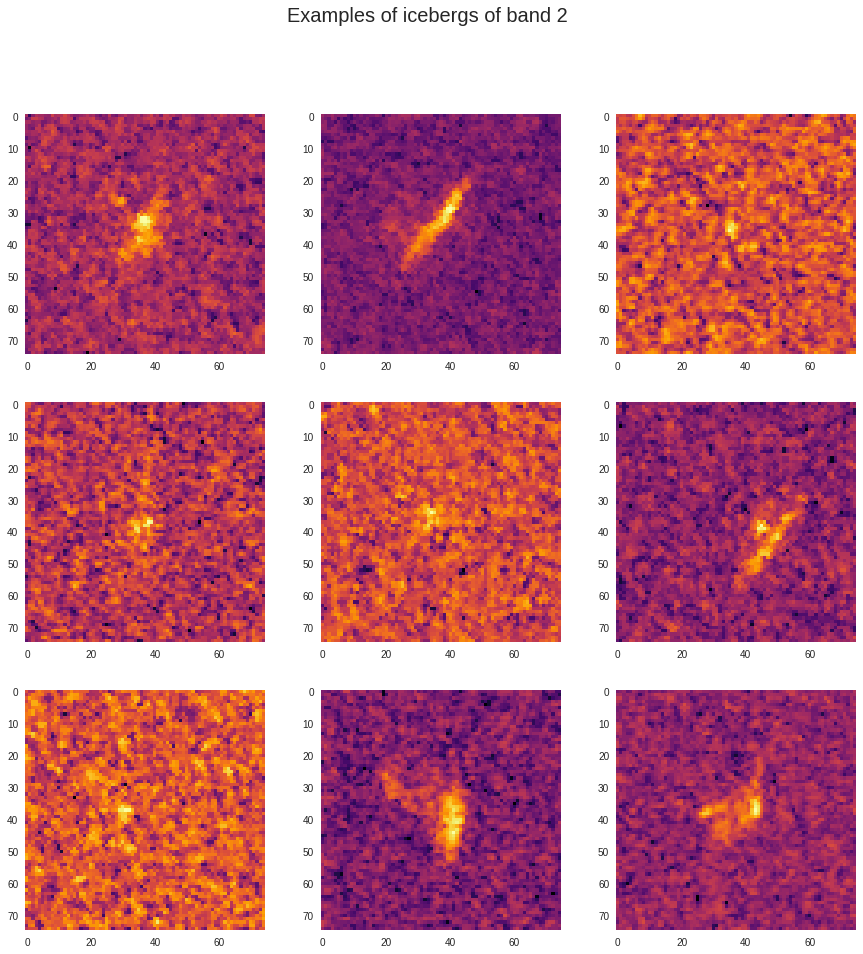

In [22]:
# Plot band_2
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
    ax.grid("False")
    ax.imshow(arr,cmap='inferno')
fig.suptitle("Examples of icebergs of band 2",fontsize=20)    
plt.show()

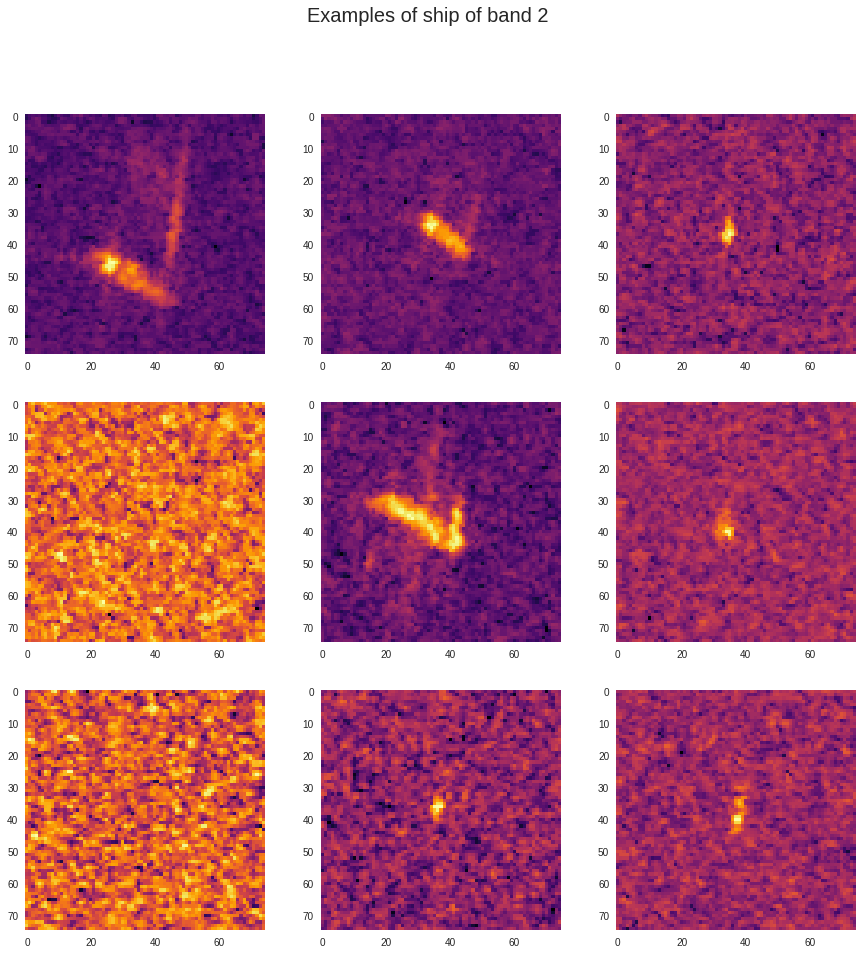

In [23]:
# Plot band_2 ships
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,1]),(75,75))
    ax.grid("False")
    ax.imshow(arr,cmap='inferno')
fig.suptitle("Examples of ship of band 2",fontsize=20)    
plt.show()

<a id='Data engineering'></a>
## 2.Data engineering

### 2.1 Reshape and scale
Need to reshape and feature scale the images: reshape the chart into [75 * 75] and scale each pixel with max- min

In [0]:
def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)

Get the train data

In [33]:
Xtrain_orig = get_scaled_imgs(df_train)
print( "The shape after reshape is:", Xtrain_orig.shape, 
      " The three dimension is band 1, band 2 and (band 1+ band 2)/2")

The shape after reshape is: (1604, 75, 75, 3)  The three dimension is band 1, band 2 and (band 1+ band 2)/2


Get the response variable "is_iceberg": to verify if the chart contains ice_berg

In [0]:
Ytrain_orig = np.array(df_train['is_iceberg'])

**Data cleaning:** Deal with the missing value: Some of the incident angle from the satellite are unknown and marked as "na". Replace these na with 0 and find the indices where the incident angle is >0 (this way you can use a truncated set or the full set of training data). neglect all the "na" data in the data sample

In [0]:
df_train.inc_angle = df_train.inc_angle.replace('na',0)
idx_tr = np.where(df_train.inc_angle>0)

You can now use the option of training with only known incident angles or the whole set. I found slightly better results training with only the known incident angles so:

In [36]:
Ytrain = Ytrain_orig[idx_tr[0]]
Xtrain = Xtrain_orig[idx_tr[0],...]
print("The remaining shape after dealing with missing value is :", Xtrain.shape)

The remaining shape after dealing with missing value is : (1471, 75, 75, 3)


### 2.2 Adding images for training(data augment)

Now, the biggest improvement I had was by adding more data to train on. I did this by simply including horizontally and vertically flipped data. Using OpenCV this is easily done. The final data will contain original chart, vertical chart and horizontal chart
link:https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#void

Parameters:

src – input array.

dst – output array of the same size and type as src. flipCode – a flag to specify how to flip the array; 0 means flipping around the x-axis and positive value (for example, 1) means flipping around y-axis. Negative value (for example, -1) means flipping around both axes (see the discussion below for the formulas).

In [0]:
def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        # vertical rotate on the first channel
        av=cv2.flip(a,1)
        # horizontal rotate on the first channel
        ah=cv2.flip(a,0)
        
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        # Stack arrays in sequence depth wise (along third axis).
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
    # combine original images, horizontal rotation and vertical rotation together   
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

I rename the returned value so i have the option of using the original data set or the expanded data set

In [0]:
Xtr_more = get_more_images(Xtrain) 

And then define the new response variable: response is just the three times of the original data, since the chart rotation will not influence the results of responses

In [0]:
# Repeat the y three times to get the responses
Ytr_more = np.concatenate((Ytrain,Ytrain,Ytrain))

## 3. CNN Keras Model
### 3.1 Training process

Convolutional neural networks (CNNs) are the current **state-of-the-art model** architecture for image classification tasks. CNNs apply a series of filters to the raw pixel data of an image to extract and learn higher-level features, which the model can then use for classification. CNNs contains three components:

**Convolutional layers**, which apply a specified number of convolution filters to the image. For each subregion, the layer performs a set of mathematical operations to produce a single value in the output feature map. Convolutional layers then typically apply a ReLU activation function to the output to introduce nonlinearities into the model.

**Pooling layers**, which downsample the image data extracted by the convolutional layers to reduce the dimensionality of the feature map in order to decrease processing time. A commonly used pooling algorithm is max pooling, which extracts subregions of the feature map (e.g., 2x2-pixel tiles), keeps their maximum value, and discards all other values.

**Dense (fully connected) layers**, which perform classification on the features extracted by the convolutional layers and downsampled by the pooling layers. In a dense layer, every node in the layer is connected to every node in the preceding layer.

Example of a CNN:

Source: http://www.mdpi.com/1099-4300/19/6/242

<img src="http://www.mdpi.com/entropy/entropy-19-00242/article_deploy/html/images/entropy-19-00242-g001.png", width="100%" height="60%" />

1) Now the nitty gritty of the situation, the CNN model. The model contains 4 cnn layers and 2 dense layers.

- The link about sequential model:https://keras.io/getting-started/sequential-model-guide/

- Link of convolutional layers: https://keras.io/layers/convolutional/

- Standford convolutinal neural network link:http://cs231n.github.io/convolutional-networks/

- Default filters glorot uniform: https://keras.io/initializers/

- Optimization function: http://ruder.io/optimizing-gradient-descent/index.html#adam

- Activation function :https://en.wikipedia.org/wiki/Activation_function

- loss function : https://isaacchanghau.github.io/2017/06/07/Loss-Functions-in-Artificial-Neural-Networks/

2) Some important parameters:

- filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

- kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.

- strides: An integer or tuple/list of a single integer, specifying the stride length of the convolution. Specifying any stride value != 1 is incompatible with specifying any  dilation_rate value != 1.

- padding: One of "valid", "causal" or "same" (case-insensitive). "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input. "causal" results in causal (dilated) convolutions, e.g. output[t] does not depend on input[t+1:]. Useful when modeling temporal data where the model should not violate the temporal order. See WaveNet: A Generative Model for Raw Audio, section 2.1.

- dilation_rate: an integer or tuple/list of a single integer, specifying the dilation rate to use for dilated convolution. Currently, specifying any dilation_rate value != 1 is incompatible with specifying any strides value != 1.

- activation: Activation function to use (see activations). If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).

### Convolutional neural network example for RGB chart 

Source : Standford cs231n course

<img src= "https://docs.google.com/uc?id=1_aFy1NSOnhREpLPGeEDIzaftYamUBAiU" width="80%" height="80%" />



In [0]:
def getModel():
    #Build keras model
    
    model=Sequential()
    
    # CNN 1
    model.add(Conv2D(filters=64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    #CNN 4
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # You must flatten the data for the dense layers: nakes it one dimension
    model.add(Flatten())

    #Dense 1
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))
    
    # choose the Adam as optimizer
    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

Now get the model and get ready to train

link to fit function: https://keras.io/models/sequential/ 

link to callbacks: https://keras.io/callbacks/

In [43]:
model = getModel()
model.summary()

#batch size
batch_size = 32
# ealy stop the model when the standard meets
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
# model save
mcp_save = ModelCheckpoint(path_model+'.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, 
                                   epsilon=1e-4, mode='min')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Fit the model with train data and return training time: batch size= 32(each time use 32 data to train), epochs= 50 (forward and backward 50 times) , validation_split ratio= 0.25 (3 parts for training and 1 part for validating)

**note that** I did not use early stop here since we need to compare the training time with GPU and without GPU
 
 

In [44]:
import time
tic = time.time()
history=model.fit(Xtr_more, Ytr_more, batch_size=batch_size, epochs=50, verbose=1, 
          callbacks=[mcp_save, reduce_lr_loss], validation_split=0.25)
print("The training time is:", time.time()-tic)

Train on 3309 samples, validate on 1104 samples
Epoch 1/50
3309/3309 [==============================] - 7s 2ms/step - loss: 0.5614 - acc: 0.7047 - val_loss: 0.3930 - val_acc: 0.8379
Epoch 2/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.3881 - acc: 0.8259 - val_loss: 0.3595 - val_acc: 0.8379
Epoch 3/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.3407 - acc: 0.8531 - val_loss: 0.3431 - val_acc: 0.8705
Epoch 4/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.2823 - acc: 0.8725 - val_loss: 0.2571 - val_acc: 0.8995
Epoch 5/50
2176/3309 [==================>...........] - ETA: 1s - loss: 0.2261 - acc: 0.9076

3309/3309 [==============================] - 5s 2ms/step - loss: 0.2321 - acc: 0.9054 - val_loss: 0.2597 - val_acc: 0.8986
Epoch 6/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.2272 - acc: 0.9060 - val_loss: 0.2432 - val_acc: 0.8976
Epoch 7/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.2147 - acc: 0.9096 - val_loss: 0.2452 - val_acc: 0.9058
Epoch 8/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.1873 - acc: 0.9220 - val_loss: 0.2333 - val_acc: 0.9121
Epoch 9/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.1836 - acc: 0.9248 - val_loss: 0.2040 - val_acc: 0.9293
Epoch 10/50
 512/3309 [===>..........................] - ETA: 3s - loss: 0.1749 - acc: 0.9102

3309/3309 [==============================] - 5s 2ms/step - loss: 0.1719 - acc: 0.9284 - val_loss: 0.2153 - val_acc: 0.9158
Epoch 11/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.1722 - acc: 0.9299 - val_loss: 0.2374 - val_acc: 0.9040
Epoch 12/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.1535 - acc: 0.9362 - val_loss: 0.2911 - val_acc: 0.8913
Epoch 13/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.1549 - acc: 0.9371 - val_loss: 0.2227 - val_acc: 0.9139
Epoch 14/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.1252 - acc: 0.9526 - val_loss: 0.2364 - val_acc: 0.9076
Epoch 15/50
 288/3309 [=>............................] - ETA: 4s - loss: 0.1277 - acc: 0.9479

3309/3309 [==============================] - 5s 2ms/step - loss: 0.1243 - acc: 0.9507 - val_loss: 0.2311 - val_acc: 0.9158
Epoch 16/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.1127 - acc: 0.9547 - val_loss: 0.2602 - val_acc: 0.9085
Epoch 17/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.1145 - acc: 0.9568 - val_loss: 0.2592 - val_acc: 0.9158

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 18/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0713 - acc: 0.9749 - val_loss: 0.2359 - val_acc: 0.9257
Epoch 19/50
3008/3309 [==========================>...] - ETA: 0s - loss: 0.0550 - acc: 0.9791

3309/3309 [==============================] - 5s 2ms/step - loss: 0.0573 - acc: 0.9779 - val_loss: 0.2423 - val_acc: 0.9248
Epoch 20/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0452 - acc: 0.9849 - val_loss: 0.2557 - val_acc: 0.9185
Epoch 21/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0410 - acc: 0.9837 - val_loss: 0.2753 - val_acc: 0.9230
Epoch 22/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0419 - acc: 0.9837 - val_loss: 0.2786 - val_acc: 0.9212
Epoch 23/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0367 - acc: 0.9879 - val_loss: 0.2793 - val_acc: 0.9239
Epoch 24/50
 640/3309 [====>.........................] - ETA: 3s - loss: 0.0381 - acc: 0.9859

3309/3309 [==============================] - 5s 2ms/step - loss: 0.0331 - acc: 0.9885 - val_loss: 0.2869 - val_acc: 0.9221

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 25/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0300 - acc: 0.9894 - val_loss: 0.2881 - val_acc: 0.9257
Epoch 26/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0280 - acc: 0.9900 - val_loss: 0.2875 - val_acc: 0.9230
Epoch 27/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0341 - acc: 0.9870 - val_loss: 0.2876 - val_acc: 0.9221
Epoch 28/50
2176/3309 [==================>...........] - ETA: 1s - loss: 0.0271 - acc: 0.9913

3309/3309 [==============================] - 5s 2ms/step - loss: 0.0265 - acc: 0.9921 - val_loss: 0.2917 - val_acc: 0.9221
Epoch 29/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0311 - acc: 0.9888 - val_loss: 0.2911 - val_acc: 0.9221
Epoch 30/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0313 - acc: 0.9885 - val_loss: 0.2915 - val_acc: 0.9221
Epoch 31/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0296 - acc: 0.9888 - val_loss: 0.2923 - val_acc: 0.9221

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 32/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0252 - acc: 0.9921 - val_loss: 0.2924 - val_acc: 0.9221
Epoch 33/50
 224/3309 [=>............................] - ETA: 4s - loss: 0.0270 - acc: 0.9866

3309/3309 [==============================] - 5s 2ms/step - loss: 0.0267 - acc: 0.9891 - val_loss: 0.2927 - val_acc: 0.9221
Epoch 34/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0279 - acc: 0.9894 - val_loss: 0.2927 - val_acc: 0.9221
Epoch 35/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0262 - acc: 0.9918 - val_loss: 0.2930 - val_acc: 0.9212
Epoch 36/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0256 - acc: 0.9906 - val_loss: 0.2930 - val_acc: 0.9221
Epoch 37/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0298 - acc: 0.9909 - val_loss: 0.2929 - val_acc: 0.9221
Epoch 38/50
 288/3309 [=>............................] - ETA: 4s - loss: 0.0268 - acc: 0.9826

3309/3309 [==============================] - 5s 2ms/step - loss: 0.0323 - acc: 0.9885 - val_loss: 0.2931 - val_acc: 0.9212

Epoch 00038: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 39/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0249 - acc: 0.9903 - val_loss: 0.2932 - val_acc: 0.9212
Epoch 40/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0270 - acc: 0.9897 - val_loss: 0.2932 - val_acc: 0.9212
Epoch 41/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0239 - acc: 0.9937 - val_loss: 0.2932 - val_acc: 0.9212
Epoch 42/50
2112/3309 [==================>...........] - ETA: 1s - loss: 0.0377 - acc: 0.9867

3309/3309 [==============================] - 5s 2ms/step - loss: 0.0330 - acc: 0.9891 - val_loss: 0.2932 - val_acc: 0.9212
Epoch 43/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0265 - acc: 0.9900 - val_loss: 0.2932 - val_acc: 0.9212
Epoch 44/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0320 - acc: 0.9870 - val_loss: 0.2932 - val_acc: 0.9212
Epoch 45/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0261 - acc: 0.9915 - val_loss: 0.2932 - val_acc: 0.9221

Epoch 00045: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 46/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0301 - acc: 0.9897 - val_loss: 0.2932 - val_acc: 0.9221
Epoch 47/50
 224/3309 [=>............................] - ETA: 4s - loss: 0.0492 - acc: 0.9821

3309/3309 [==============================] - 5s 2ms/step - loss: 0.0321 - acc: 0.9888 - val_loss: 0.2933 - val_acc: 0.9221
Epoch 48/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0277 - acc: 0.9906 - val_loss: 0.2933 - val_acc: 0.9221
Epoch 49/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0317 - acc: 0.9885 - val_loss: 0.2933 - val_acc: 0.9221
Epoch 50/50
3309/3309 [==============================] - 5s 2ms/step - loss: 0.0280 - acc: 0.9915 - val_loss: 0.2933 - val_acc: 0.9212
The training time is: 264.88771295547485


I use 50 epochs to train the model and use 10 epochs to compare the time

The training time with GPU  for 10 epochs is : 54.9569149017334

The training time with CPU for 10 epochs is : 970.8762226104736

around 18 times acceleration via using GPU

Time for training 50 epochs is 264.88771295547485s

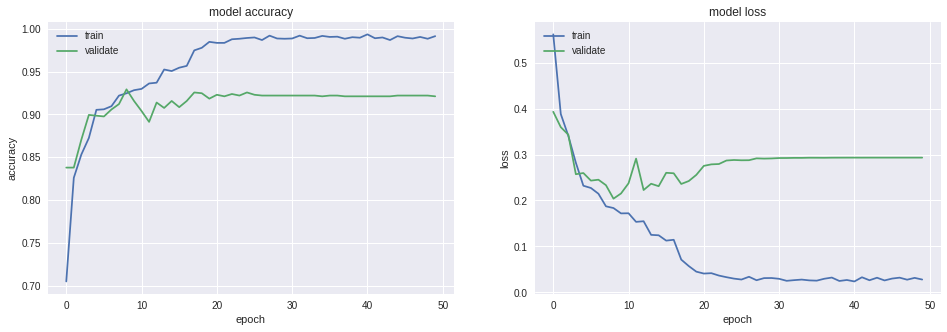

In [45]:
#plot the accuracy and validation loss
import matplotlib.pylab as plt
# adjust the figure size 
plt.figure(figsize=(16,5)) 

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.savefig(path_fig + "accuracy.jpeg")
plt.show()

**Conclusion: **

1) Train accuracy improves when epochs increases, similar with train loss. However not too much overfitting.

2) Test accuracy does not tend to improve when epochs beyond 20, similar with test loss. However not too much overfitting

3) If we use early stop, the best time for stopping may around 20 epochs. Can save time with less training.


### 3.2 Testing process

Load the best weights and check the score on the training data.

In [46]:
model.load_weights(filepath = path_model+'.mdl_wts.hdf5')

score = model.evaluate(Xtrain, Ytrain, verbose=1)
print('Train score:', score[0])
print('Train accuracy:', score[1])

1471/1471 [==============================] - 1s 552us/step
Train score: 0.11743594923345999
Train accuracy: 0.9592114208021754


Load the test data and print shape

In [47]:
df_test = pd.read_json(path_data + 'test.json')
print("The shape of test data is : ", df_test.shape)


The shape of test data is :  (8424, 4)


Predict the classes of test data and save to file

Logloss of binary problem: $-(ylog(p)+(1-y)log(1-p))$

Logloss of multi-class classification: $-\sum_{c=1}^M y_{o,c}log(p_{o,c})$

Definition of Logloss: http://wiki.fast.ai/index.php/Log_Loss

Submissions in this project are evaluated on the log loss between the predicted values and the ground truth



In [48]:
df_test.inc_angle = df_test.inc_angle.replace('na',0)
Xtest = (get_scaled_imgs(df_test))
pred_test = model.predict(Xtest)

# save the reuslt to a file 
submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
print(submission.head(10))
submission.to_csv(path_data + 'submission.csv', index=False)

         id    is_iceberg
0  5941774d  3.742499e-02
1  4023181e  8.933902e-01
2  b20200e4  2.029254e-03
3  e7f018bb  9.995655e-01
4  4371c8c3  9.858520e-01
5  a8d9b1fd  7.978809e-02
6  29e7727e  8.538661e-02
7  92a51ffb  9.999520e-01
8  c769ac97  1.555283e-05
9  aee0547d  8.908529e-07


The score for this submission is 0.1886

## 4.Pseudo labeling 
Use the model to predict the test data and use the result as label to retrain the train+test data. Use the retrained model with pseudo labeling data to predict the test sample. 

First, predict the classes for the test data.

In [0]:
pred_test_classes = model.predict_classes(Xtest)
# combine the train data and test data with label together
x_train_total=np.concatenate((Xtest,Xtr_more),axis=0)
y_train_total=np.concatenate((Ytr_more[:,np.newaxis],pred_test_classes),axis =0)

Train model with total data

In [50]:
import time 
tic=time.time()
model.fit(x_train_total, y_train_total, batch_size=batch_size, epochs=50, 
          verbose=1, callbacks=[mcp_save, reduce_lr_loss], validation_split=0.25)
print("The time for training the model is :", time.time()-tic)

Train on 9627 samples, validate on 3210 samples
Epoch 1/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3801 - acc: 0.5116 - val_loss: 2.8860 - val_acc: 0.4813
Epoch 2/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3694 - acc: 0.5105 - val_loss: 2.8811 - val_acc: 0.4813
Epoch 3/50
5248/9627 [===============>..............] - ETA: 6s - loss: 2.4038 - acc: 0.5105

9627/9627 [==============================] - 15s 2ms/step - loss: 2.3561 - acc: 0.5124 - val_loss: 2.8770 - val_acc: 0.4816
Epoch 4/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3427 - acc: 0.5117 - val_loss: 2.8734 - val_acc: 0.4816
Epoch 5/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3626 - acc: 0.5115 - val_loss: 2.8700 - val_acc: 0.4816
Epoch 6/50
 800/9627 [=>............................] - ETA: 12s - loss: 2.2676 - acc: 0.5138

9627/9627 [==============================] - 15s 2ms/step - loss: 2.3459 - acc: 0.5108 - val_loss: 2.8667 - val_acc: 0.4816
Epoch 7/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3444 - acc: 0.5097 - val_loss: 2.8636 - val_acc: 0.4813
Epoch 8/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3391 - acc: 0.5101 - val_loss: 2.8605 - val_acc: 0.4813
Epoch 9/50
  96/9627 [..............................] - ETA: 12s - loss: 1.9538 - acc: 0.5729

9627/9627 [==============================] - 15s 2ms/step - loss: 2.3468 - acc: 0.5122 - val_loss: 2.8574 - val_acc: 0.4813
Epoch 10/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3416 - acc: 0.5059 - val_loss: 2.8544 - val_acc: 0.4810
Epoch 11/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3521 - acc: 0.5094 - val_loss: 2.8515 - val_acc: 0.4810


Epoch 12/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3460 - acc: 0.5106 - val_loss: 2.8485 - val_acc: 0.4810
Epoch 13/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3449 - acc: 0.5119 - val_loss: 2.8456 - val_acc: 0.4810
Epoch 14/50
8576/9627 [=========================>....] - ETA: 1s - loss: 2.3362 - acc: 0.5110

9627/9627 [==============================] - 15s 2ms/step - loss: 2.3366 - acc: 0.5111 - val_loss: 2.8427 - val_acc: 0.4810
Epoch 15/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3231 - acc: 0.5111 - val_loss: 2.8397 - val_acc: 0.4810
Epoch 16/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3368 - acc: 0.5103 - val_loss: 2.8368 - val_acc: 0.4810
Epoch 17/50
1248/9627 [==>...........................] - ETA: 11s - loss: 2.3795 - acc: 0.4880

9627/9627 [==============================] - 15s 2ms/step - loss: 2.3312 - acc: 0.5120 - val_loss: 2.8338 - val_acc: 0.4807
Epoch 18/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3207 - acc: 0.5118 - val_loss: 2.8309 - val_acc: 0.4807
Epoch 19/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3266 - acc: 0.5087 - val_loss: 2.8280 - val_acc: 0.4810


Epoch 20/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3287 - acc: 0.5104 - val_loss: 2.8250 - val_acc: 0.4810
Epoch 21/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3173 - acc: 0.5112 - val_loss: 2.8221 - val_acc: 0.4810
Epoch 22/50
8576/9627 [=========================>....] - ETA: 1s - loss: 2.3347 - acc: 0.5076

9627/9627 [==============================] - 15s 2ms/step - loss: 2.3229 - acc: 0.5098 - val_loss: 2.8191 - val_acc: 0.4807
Epoch 23/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3114 - acc: 0.5137 - val_loss: 2.8162 - val_acc: 0.4807
Epoch 24/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3087 - acc: 0.5119 - val_loss: 2.8132 - val_acc: 0.4807
Epoch 25/50
1120/9627 [==>...........................] - ETA: 12s - loss: 2.2389 - acc: 0.5304

9627/9627 [==============================] - 15s 2ms/step - loss: 2.3065 - acc: 0.5100 - val_loss: 2.8103 - val_acc: 0.4804
Epoch 26/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.2946 - acc: 0.5102 - val_loss: 2.8074 - val_acc: 0.4807
Epoch 27/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3010 - acc: 0.5101 - val_loss: 2.8045 - val_acc: 0.4807
Epoch 28/50
  32/9627 [..............................] - ETA: 13s - loss: 2.2079 - acc: 0.5625

9627/9627 [==============================] - 15s 2ms/step - loss: 2.3046 - acc: 0.5108 - val_loss: 2.8015 - val_acc: 0.4810
Epoch 29/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.3020 - acc: 0.5113 - val_loss: 2.7986 - val_acc: 0.4810
Epoch 30/50
9440/9627 [============================>.] - ETA: 0s - loss: 2.2947 - acc: 0.5091

9627/9627 [==============================] - 15s 2ms/step - loss: 2.2958 - acc: 0.5091 - val_loss: 2.7957 - val_acc: 0.4810
Epoch 31/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.2865 - acc: 0.5132 - val_loss: 2.7928 - val_acc: 0.4810
Epoch 32/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.2941 - acc: 0.5090 - val_loss: 2.7899 - val_acc: 0.4810
Epoch 33/50
1440/9627 [===>..........................] - ETA: 11s - loss: 2.2241 - acc: 0.5125

9627/9627 [==============================] - 15s 2ms/step - loss: 2.2987 - acc: 0.5101 - val_loss: 2.7870 - val_acc: 0.4810
Epoch 34/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.2866 - acc: 0.5113 - val_loss: 2.7840 - val_acc: 0.4810
Epoch 35/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.2760 - acc: 0.5120 - val_loss: 2.7812 - val_acc: 0.4810
Epoch 36/50
  96/9627 [..............................] - ETA: 13s - loss: 2.5602 - acc: 0.5104

9627/9627 [==============================] - 15s 2ms/step - loss: 2.2707 - acc: 0.5100 - val_loss: 2.7783 - val_acc: 0.4810
Epoch 37/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.2729 - acc: 0.5129 - val_loss: 2.7754 - val_acc: 0.4810
Epoch 38/50
9568/9627 [============================>.] - ETA: 0s - loss: 2.2857 - acc: 0.5097

9627/9627 [==============================] - 15s 2ms/step - loss: 2.2826 - acc: 0.5100 - val_loss: 2.7724 - val_acc: 0.4813
Epoch 39/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.2732 - acc: 0.5105 - val_loss: 2.7695 - val_acc: 0.4813
Epoch 40/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.2559 - acc: 0.5132 - val_loss: 2.7666 - val_acc: 0.4813
Epoch 41/50
1440/9627 [===>..........................] - ETA: 11s - loss: 2.4262 - acc: 0.4910

9627/9627 [==============================] - 15s 2ms/step - loss: 2.2656 - acc: 0.5126 - val_loss: 2.7637 - val_acc: 0.4810
Epoch 42/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.2745 - acc: 0.5114 - val_loss: 2.7609 - val_acc: 0.4810
Epoch 43/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.2617 - acc: 0.5108 - val_loss: 2.7580 - val_acc: 0.4813
Epoch 44/50
  32/9627 [..............................] - ETA: 13s - loss: 1.6239 - acc: 0.5938

9627/9627 [==============================] - 15s 2ms/step - loss: 2.2618 - acc: 0.5105 - val_loss: 2.7551 - val_acc: 0.4813
Epoch 45/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.2626 - acc: 0.5110 - val_loss: 2.7521 - val_acc: 0.4810
Epoch 46/50
9568/9627 [============================>.] - ETA: 0s - loss: 2.2596 - acc: 0.5094

9627/9627 [==============================] - 15s 2ms/step - loss: 2.2598 - acc: 0.5098 - val_loss: 2.7493 - val_acc: 0.4810
Epoch 47/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.2521 - acc: 0.5094 - val_loss: 2.7464 - val_acc: 0.4816
Epoch 48/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.2474 - acc: 0.5079 - val_loss: 2.7436 - val_acc: 0.4816
Epoch 49/50
1408/9627 [===>..........................] - ETA: 11s - loss: 2.2100 - acc: 0.5199

9627/9627 [==============================] - 15s 2ms/step - loss: 2.2533 - acc: 0.5114 - val_loss: 2.7406 - val_acc: 0.4816
Epoch 50/50
9627/9627 [==============================] - 15s 2ms/step - loss: 2.2519 - acc: 0.5124 - val_loss: 2.7377 - val_acc: 0.4816
The time for training the model is : 737.621503829956


Use the new model to predict the test data, fisrt to see the train accuracy and then the test result


In [51]:
score = model.evaluate(x_train_total, y_train_total, verbose=1)
print('Train score:', score[0])
print('Train accuracy:', score[1])

pred_test = model.predict(Xtest)
# save to a file
submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
print(submission.head(10))

submission.to_csv(path_data + 'submission_psuedo.csv', index=False)

12837/12837 [==============================] - 6s 468us/step
Train score: 2.255165382282955
Train accuracy: 0.49918205188360226
         id  is_iceberg
0  5941774d    0.035522
1  4023181e    0.903028
2  b20200e4    0.003213
3  e7f018bb    0.999388
4  4371c8c3    0.983153
5  a8d9b1fd    0.100231
6  29e7727e    0.097158
7  92a51ffb    0.999918
8  c769ac97    0.000032
9  aee0547d    0.000002


The submission of psuedo labelling is 0.1877, a little bit improvement compared with no psuedo labelling

## 5. Stacking

Using the results of five different models to get a comprehensive result

Link: https://www.quora.com/What-is-stacking-in-machine-learning

<img src= "https://docs.google.com/uc?id=1Mfi1SLjNtzmQ48MDS08uzrogKexDECu9" width="50%" height="50%" />


### 5.1 Data Load

In [52]:
import os
# find the file names in the path_stack

all_files = os.listdir(path_stack)

# Read and concatenate submissions
outs = [pd.read_csv(os.path.join(path_stack, f), index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "is_iceberg_" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
concat_sub.head()

,id,is_iceberg_0,is_iceberg_1,is_iceberg_2,is_iceberg_3,is_iceberg_4
0,5941774d,1.943216e-02,0.008171,0.010215,0.005586,0.094676
1,4023181e,3.168809e-02,0.638348,0.237662,0.145927,0.952222
2,b20200e4,4.000000e-08,0.008061,1.000000,0.000015,0.167771
3,e7f018bb,9.925741e-01,0.999506,0.999533,0.999914,0.989356
4,4371c8c3,2.215107e-02,0.774739,0.994269,0.033843,0.900321


In [53]:
# check their correlation
concat_sub.corr()

,is_iceberg_0,is_iceberg_1,is_iceberg_2,is_iceberg_3,is_iceberg_4
is_iceberg_0,1.000000,0.809320,0.516280,0.890434,0.420791
is_iceberg_1,0.809320,1.000000,0.490128,0.789509,0.489134
is_iceberg_2,0.516280,0.490128,1.000000,0.548663,0.432111
is_iceberg_3,0.890434,0.789509,0.548663,1.000000,0.493308
is_iceberg_4,0.420791,0.489134,0.432111,0.493308,1.000000


In [0]:
# get the data fields ready for stacking
concat_sub['is_iceberg_max'] = concat_sub.iloc[:, 1:6].max(axis=1)
concat_sub['is_iceberg_min'] = concat_sub.iloc[:, 1:6].min(axis=1)
concat_sub['is_iceberg_mean'] = concat_sub.iloc[:, 1:6].mean(axis=1)
concat_sub['is_iceberg_median'] = concat_sub.iloc[:, 1:6].median(axis=1)

In [0]:
# set up a cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

### 5.2 Mean stacking
Take the mean of five results

In [0]:
concat_sub['is_iceberg'] = concat_sub['is_iceberg_mean']
concat_sub[['id', 'is_iceberg']].to_csv(path_data+'stack_mean.csv', 
                                        index=False, float_format='%.6f')

**LB 0.1698** , decent first try - still some gap comparing with our top-line model performance in stack.

### 5.3 Median stacking
Take the median of five results

In [0]:
concat_sub['is_iceberg'] = concat_sub['is_iceberg_median']
concat_sub[['id', 'is_iceberg']].to_csv(path_data+'stack_median.csv', 
                                        index=False, float_format='%.6f')

**LB 0.1575**, very close with our top-line model performance, but we want to see some improvement at least0

###5.4 PushOut + Median Stacking 
Set the reuslt as 1 when all the five results are bigger than low cutoff and as 0 when all the results are less than high cutoff

In [0]:
concat_sub['is_iceberg'] = np.where(np.all(concat_sub.iloc[:,1:6] > cutoff_lo, axis=1), 1, 
                                    np.where(np.all(concat_sub.iloc[:,1:6] < cutoff_hi, axis=1),
                                             0, concat_sub['is_iceberg_median']))
concat_sub[['id', 'is_iceberg']].to_csv(path_data+'stack_pushout_median.csv', 
                                        index=False, float_format='%.6f')

**LB 0.1940**, not very impressive results given the base models in the pipeline...

### 5.5 MinMax + Mean Stacking
Set the results as max when all the five results bigger than low cutoff , as min when all the five results less than high cutoff, otherwise, the result is mean

In [0]:
concat_sub['is_iceberg'] = np.where(np.all(concat_sub.iloc[:,1:6] > cutoff_lo, axis=1), 
                                    concat_sub['is_iceberg_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:6] < cutoff_hi, axis=1),
                                             concat_sub['is_iceberg_min'], 
                                             concat_sub['is_iceberg_mean']))
concat_sub[['id', 'is_iceberg']].to_csv(path_data+'stack_minmax_mean.csv', 
                                        index=False, float_format='%.6f')

**LB 0.1622**, need to stack with Median to see the results.

###5.6 MinMax + Median Stacking 

Set the results as max when all the five results bigger than low cutoff , as min when all the five results less than high cutoff, otherwise, the result is median

In [0]:
concat_sub['is_iceberg'] = np.where(np.all(concat_sub.iloc[:,1:6] > cutoff_lo, axis=1), 
                                    concat_sub['is_iceberg_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:6] < cutoff_hi, axis=1),
                                             concat_sub['is_iceberg_min'], 
                                             concat_sub['is_iceberg_median']))
concat_sub[['id', 'is_iceberg']].to_csv(path_data+'stack_minmax_median.csv', 
                                        index=False, float_format='%.6f')

**LB 0.1488** - **Great!** This is an improvement to our top-line model performance

